El dataset tiene las transacciones de usuarios que realizaron en una determinada tienda 
de Uruguay. El dataset tiene el numero de la factura, el id del usuario, la fecha, el valor del producto
y el id del producto. Una misma factura puede tener mas de un producto

# Libraries

In [5]:
#install.packages('hexbin')
#install.packages('randomForest')
#install.packages('rfUtilities')

In [6]:
library(tidyverse)
library(lubridate)
library(caret)
library(ranger)
library(vip)
library(randomForest)
library(rfUtilities)
library(pdp)

# Load Raw Dataset
EL dataset tiene las columnas:
* Factura
* Fecha
* Customer_ID
* Sexo
* Venta ($)
* Ciudad
* Product ID

In [7]:
col_types <- cols(
    Factura = col_character(),
    Fecha = col_character(),
    Customer_ID = col_character(),
    Sexo = col_character(),
    `Venta ($)` = col_character(),
    Ciudad = col_character(),
    `Product ID` = col_integer()
)

#path = '../data/Final Project Dataset.csv'
path = 'https://www.dropbox.com/s/f3bzfsju7p1sakz/Final%20Project%20Dataset.csv?dl=1'
df_raw <- readr::read_delim(path, ',', col_types = col_types)

# Parse correct data types

In [8]:
df <- df_raw  %>% 
    rename(sale_price = 'Venta ($)',
           product_id = 'Product ID',
           sale_date = Fecha,
           invoice = Factura,
           city = Ciudad,
           sex= Sexo) %>% 
    select(-sex) %>% 
    rename_with(~ tolower(gsub(" ", "_", .x, fixed = TRUE))) %>% 
    mutate(sale_date = parse_date(sale_date, "%d/%m/%Y"),
           sale_price = str_replace(sale_price, "-", "0"),
           sale_price = str_replace(sale_price, "\\(", "-"),
           sale_price = str_replace(sale_price, "\\)", ""),
           sale_price = parse_number(sale_price,
                                     locale = locale(decimal_mark = ",", grouping_mark = "."),
                                     na = c("", "NA", "--", "-")))
head(df)

invoice,sale_date,customer_id,sale_price,city,product_id
<chr>,<date>,<chr>,<dbl>,<chr>,<int>
227837,2019-08-23,175335,2901,Rivera,4
227832,2019-08-23,140862,7256,Montevideo Periferia,19
227831,2019-08-23,225831,2901,Durazno,4
227826,2019-08-23,185845,4462,Montevideo Periferia,0
227823,2019-08-23,153566,2901,Rivera,4
227821,2019-08-23,164715,2214,Paysandú,3


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



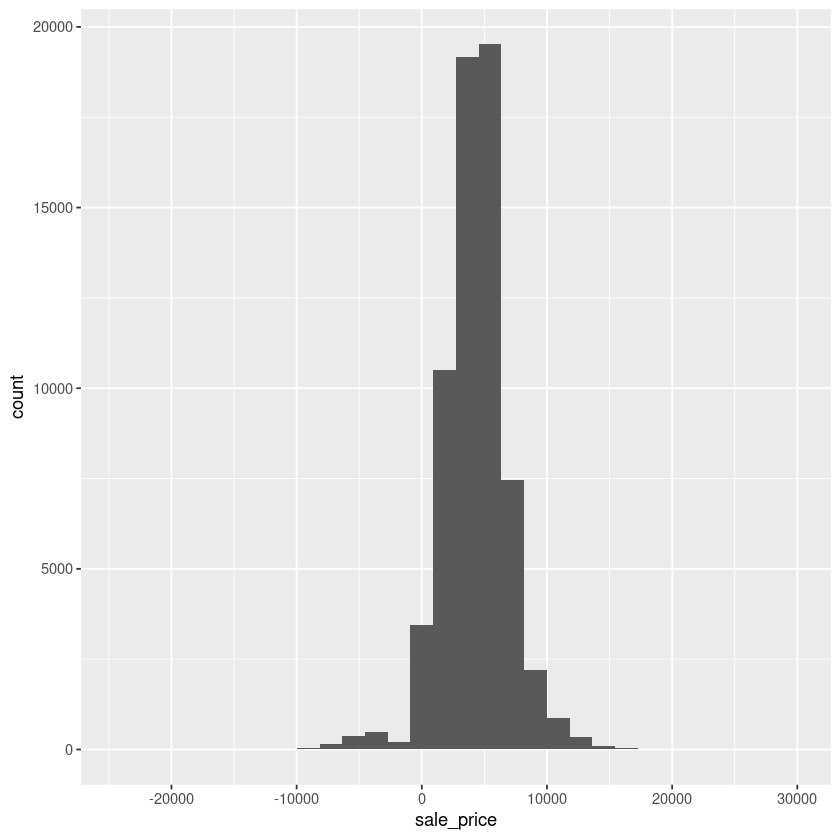

In [9]:
df %>% 
    ggplot(aes(sale_price)) +
        geom_histogram()

# Cleanning and transformation

## missing values

In [10]:
cheack_missing <- function(df){
    t(data.frame(n_missing = sapply(df, function(x) sum(is.na(x))),
                 perc_missing = sapply(df, function(x) as.integer(mean(is.na(x))*100))))
}
cheack_missing(df)                                                             

,invoice,sale_date,customer_id,sale_price,city,product_id
n_missing,9377,0,1,0,0,0
perc_missing,14,0,0,0,0,0


## Como imputar los missing values para las facturas
* Posible estrategia seria llenar con un numero random todas las compras de un usuario en el mismo dia


In [20]:
df <- df %>% 
    mutate(transaction_id = group_indices(., sale_date, customer_id),
           refound = ifelse(sale_price < 0, 1, 0)
          )


In [21]:
head(df)

invoice,sale_date,customer_id,sale_price,city,product_id,transaction_id,refound
<chr>,<date>,<chr>,<dbl>,<chr>,<int>,<int>,<dbl>
227837,2019-08-23,175335,2901,Rivera,4,48097,0
227832,2019-08-23,140862,7256,Montevideo Periferia,19,48013,0
227831,2019-08-23,225831,2901,Durazno,4,48151,0
227826,2019-08-23,185845,4462,Montevideo Periferia,0,48119,0
227823,2019-08-23,153566,2901,Rivera,4,48028,0
227821,2019-08-23,164715,2214,Paysandú,3,48064,0


## Filtrado de las transacciones validas 

In [22]:
df_clean <- df %>% 
    filter(!is.na(sale_price),
           !is.na(customer_id)) %>% 
    select(-invoice)

In [23]:
cheack_missing(df_clean)

,sale_date,customer_id,sale_price,city,product_id,transaction_id,refound
n_missing,0,0,0,0,0,0,0
perc_missing,0,0,0,0,0,0,0


In [24]:
summary(df_clean)

   sale_date          customer_id          sale_price         city          
 Min.   :2018-01-02   Length:65007       Min.   :-24327   Length:65007      
 1st Qu.:2018-07-10   Class :character   1st Qu.:  2819   Class :character  
 Median :2018-12-13   Mode  :character   Median :  4353   Mode  :character  
 Mean   :2018-12-05                      Mean   :  4324                     
 3rd Qu.:2019-05-06                      3rd Qu.:  5808                     
 Max.   :2019-08-31                      Max.   : 28324                     
   product_id     transaction_id     refound       
 Min.   : 0.000   Min.   :    1   Min.   :0.00000  
 1st Qu.: 2.000   1st Qu.:12536   1st Qu.:0.00000  
 Median : 4.000   Median :24701   Median :0.00000  
 Mean   : 6.715   Mean   :24866   Mean   :0.02071  
 3rd Qu.: 9.000   3rd Qu.:37018   3rd Qu.:0.00000  
 Max.   :79.000   Max.   :50269   Max.   :1.00000  

## Feature engineering
- Considerar las devoluciones
 - restar al promedio de compra y disminumir el numero de productos comprados 2 *  n negativos
 - contar cuantas negativos por usuarios
- contar cuantos productos iguales a 0
- no contar esos productos en el proceso de promedios

### Detalle de la compra

In [26]:
resume_transaction  <- df_clean %>% 
    group_by(customer_id, transaction_id) %>% 
    summarise(sale_date=max(sale_date),
              city = max(city),
              n_prod = n(),
              n_refound = sum(refound),
              sale_total = sum(sale_price[sale_price>0]),
              refound_total = sum(sale_price[sale_price<0]),
              n_item_by_trans = n_distinct(product_id),
              is_weekend = wday(sale_price) %in% c(1,7), 
              .groups = 'drop'
             ) %>% 
    mutate(purchase_age = as.integer(max(sale_date)-sale_date),
           city = str_to_lower(str_replace_all(city, ' ', '_')))

resume_transaction[sample(1:nrow(resume_transaction), 10),]

customer_id,transaction_id,sale_date,city,n_prod,n_refound,sale_total,refound_total,n_item_by_trans,is_weekend,purchase_age
<chr>,<int>,<date>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<int>
150912,25592,2018-12-22,flores,1,0,2416,0,1,FALSE,252
136351,13,2018-01-02,montevideo_periferia,1,0,6533,0,1,FALSE,606
161072,24094,2018-12-06,montevideo_periferia,1,0,4356,0,1,FALSE,268
103960,16917,2018-09-05,rivera,2,0,15730,0,2,FALSE,360
146365,94,2018-01-03,montevideo_céntrico,3,0,5861,0,3,FALSE,605
170207,5926,2018-04-20,artigas,3,0,15727,0,3,FALSE,498
175224,13522,2018-07-24,montevideo_periferia,2,0,5082,0,2,FALSE,403
176796,1884,2018-02-14,treinta_y_tres,1,0,9075,0,1,FALSE,563
221278,6883,2018-05-03,paysandú,1,0,0,0,1,FALSE,485


In [29]:
resume_transaction %>% 
    filter(n_refound>0) %>% 
    head()
    #ggplot(aes(sale_total)) + geom_histogram()

customer_id,transaction_id,sale_date,city,n_prod,n_refound,sale_total,refound_total,n_item_by_trans,is_weekend,purchase_age
<chr>,<int>,<date>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<int>
100006,6897,2018-05-04,salto,1,1,0,-2538,1,FALSE,484
100143,25426,2018-12-21,flores,1,1,0,-1879,1,FALSE,253
100316,572,2018-01-17,treinta_y_tres,1,1,0,-5075,1,FALSE,591
100335,4313,2018-03-28,montevideo_céntrico,1,1,0,-4033,1,FALSE,521
100393,16497,2018-08-31,montevideo_céntrico,1,1,0,-5442,1,FALSE,365
100581,33174,2019-03-29,rocha,1,1,0,-3630,1,FALSE,155


### Detalles del customer

In [13]:
resume_customer  <- resume_transaction %>% 
    group_by(customer_id) %>% 
    summarise(n_purchase = n(),  # frecuencia
              n_products = sum(n_prod),
              n_products_avg = mean(n_prod),
              last_purchase = min(purchase_age),
              customer_age = as.integer(max(sale_date)-min(sale_date)),
              n_cities = n_distinct(city),
              sale_avg = sum(sale_total)/sum(n_prod),
              item_by_trans_avg = mean(n_item_by_trans),
              ratio_week = mean(is_weekend),
              .groups = 'drop'
             ) %>% 
    arrange(n_purchase)

resume_customer[sample(1:nrow(resume_customer), 10),]

customer_id,n_purchase,n_products,n_products_avg,last_purchase,customer_age,n_cities,sale_avg,item_by_trans_avg,ratio_week
<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
179940,8,14,1.750000,10,566,3,4481.214,1.750000,0
187375,6,10,1.666667,0,184,2,2655.700,1.666667,0
134718,4,4,1.000000,143,337,4,3559.250,1.000000,0
225228,5,11,2.200000,123,417,1,2091.727,2.200000,0
163022,7,9,1.285714,54,516,2,4344.667,1.000000,0
145256,5,5,1.000000,9,461,2,5112.400,1.000000,0
204297,1,1,1.000000,336,0,1,4356.000,1.000000,0
181703,4,6,1.500000,294,238,1,2586.000,1.500000,0
200732,6,12,2.000000,280,208,3,4915.000,2.000000,0


### Detalle del las ciudades de compra x usuario

In [14]:
resume_city = resume_transaction %>%
    group_by(customer_id) %>% 
    mutate(n=n()) %>% 
    group_by(city, .add = TRUE) %>% 
    summarise(n_avg = as.numeric(n()/n), .groups = 'drop') %>% 
    ungroup()  %>% 
    pivot_wider(
        names_from = city,
        values_from = n_avg,
        values_fn=max, 
        values_fill=0,
        names_prefix="city_",
    )
head(resume_city)

customer_id,city_salto,city_montevideo_céntrico,city_artigas,city_montevideo_periferia,city_flores,city_treinta_y_tres,city_paysandú,city_rivera,city_rocha,city_fray_bentos,city_maldonado,city_colonia,city_soriano,city_florida,city_san_josé,city_canelones,city_cerro_largo,city_tacuarembó,city_durazno
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
06444-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100006,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100029,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100032,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100046,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100058,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Join Customer + Ciudad

In [15]:
full_customer = inner_join(x=resume_customer, y=resume_city, by="customer_id")

glimpse(full_customer)

Rows: 22,060
Columns: 29
$ customer_id               <chr> "06444-", "100032", "100046", "100058", "10…
$ n_purchase                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_products                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_products_avg            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ last_purchase             <int> 38, 49, 549, 158, 446, 53, 355, 240, 513, 1…
$ customer_age              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_cities                  <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ sale_avg                  <dbl> 13062, 4716, 6046, 6853, 2541, 6531, 4558, …
$ item_by_trans_avg         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ ratio_week                <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ city_salto                <dbl> 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0…
$ city_montevideo_céntrico  <dbl> 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0…
$ city_artigas             

# Definicion de Churn

In [16]:
churn_thr <- 120
churn_raw <- full_customer %>% 
    mutate(churn = last_purchase > churn_thr,
           churn = as.integer(churn)) %>% 
    select(!c(last_purchase, customer_id))
    

In [17]:
glimpse(churn_raw)

Rows: 22,060
Columns: 28
$ n_purchase                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_products                <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_products_avg            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ customer_age              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_cities                  <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ sale_avg                  <dbl> 13062, 4716, 6046, 6853, 2541, 6531, 4558, …
$ item_by_trans_avg         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ ratio_week                <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ city_salto                <dbl> 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0…
$ city_montevideo_céntrico  <dbl> 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0…
$ city_artigas              <dbl> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ city_montevideo_periferia <dbl> 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0…
$ city_flores              

# Split Train/Test

In [18]:
index_split <- as.vector(createDataPartition(churn_raw$churn, p = 0.8, list = FALSE, ))
churn_train <- churn_raw[index_split, ]
churn_test <- churn_raw[-index_split, ]

# EDA

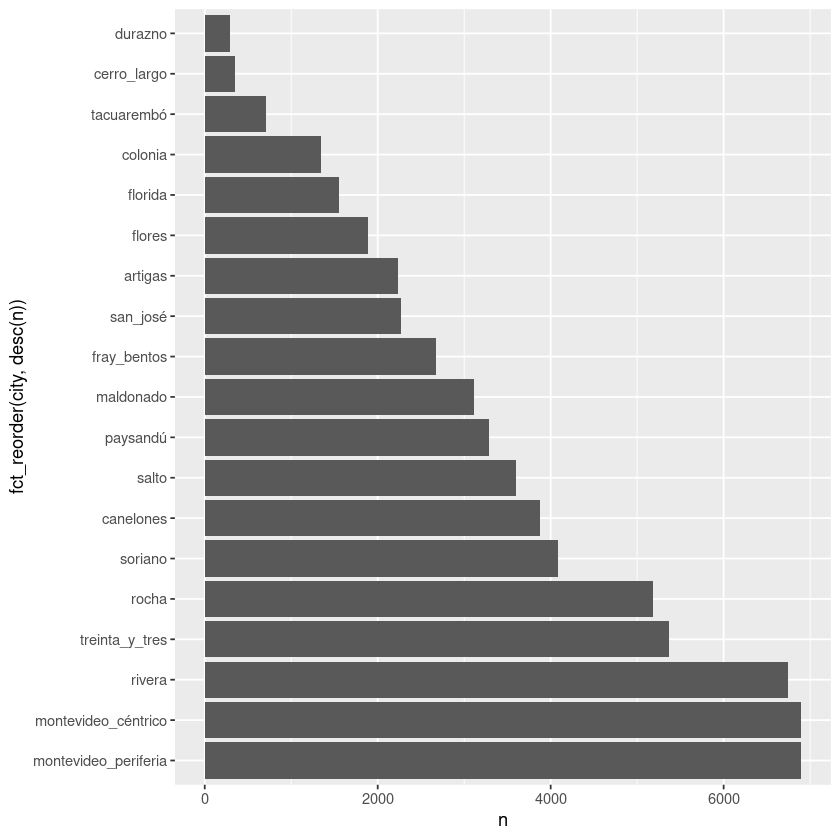

In [19]:
resume_transaction %>% 
    group_by(city) %>% 
    count() %>% 
    ungroup() %>% 
    arrange(n) %>% 
    ggplot(aes(x=fct_reorder(city, desc(n)), y=n)) +
        geom_bar(stat="identity") +
        coord_flip() 

In [20]:
resume_transaction %>% 
    group_by(customer_id) %>% 
    summarise(n_distinct = n_distinct(city), .groups = 'drop') %>% 
    count(n_distinct)

n_distinct,n
<int>,<int>
1,16472
2,3890
3,1138
4,396
5,115
6,32
7,13
8,2
9,1


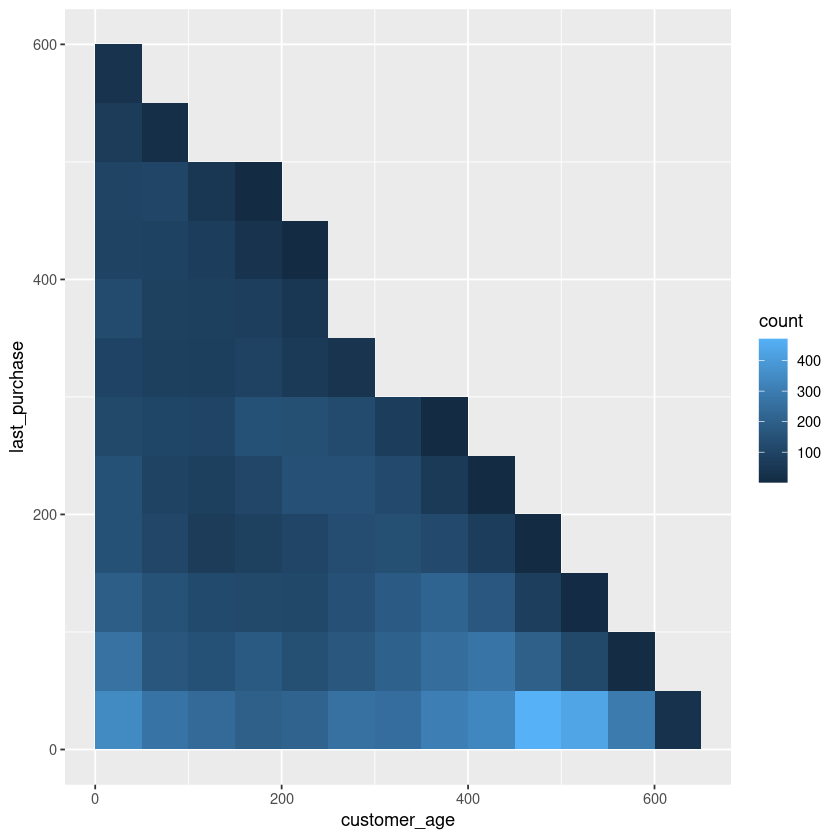

In [21]:
resume_customer %>% 
    filter(customer_age > 0) %>% 
    ggplot(aes(y=last_purchase, x=customer_age)) + geom_bin2d(binwidth=c(50, 50))

Warning message:
“Removed 7 rows containing non-finite values (stat_bin2d).”


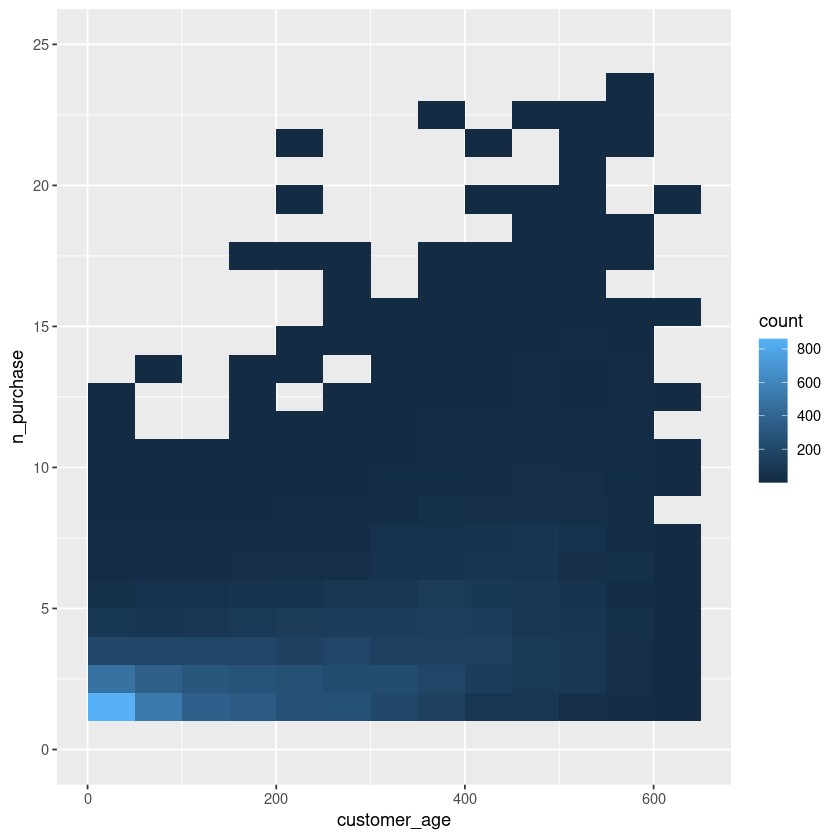

In [22]:
resume_customer %>% 
    filter(customer_age > 0) %>% 
    ggplot(aes(y=n_purchase, x=customer_age)) +
        geom_bin2d(binwidth=c(50, 1)) +
        ylim(0, 25)

In [23]:
resume_customer %>% 
    filter(customer_age > 0) %>% 
    mutate(thr = last_purchase > 250) %>% 
    summarise(thr_mean = mean(thr))


thr_mean
<dbl>
0.2026138


Warning message:
“Removed 20 rows containing non-finite values (stat_bin2d).”


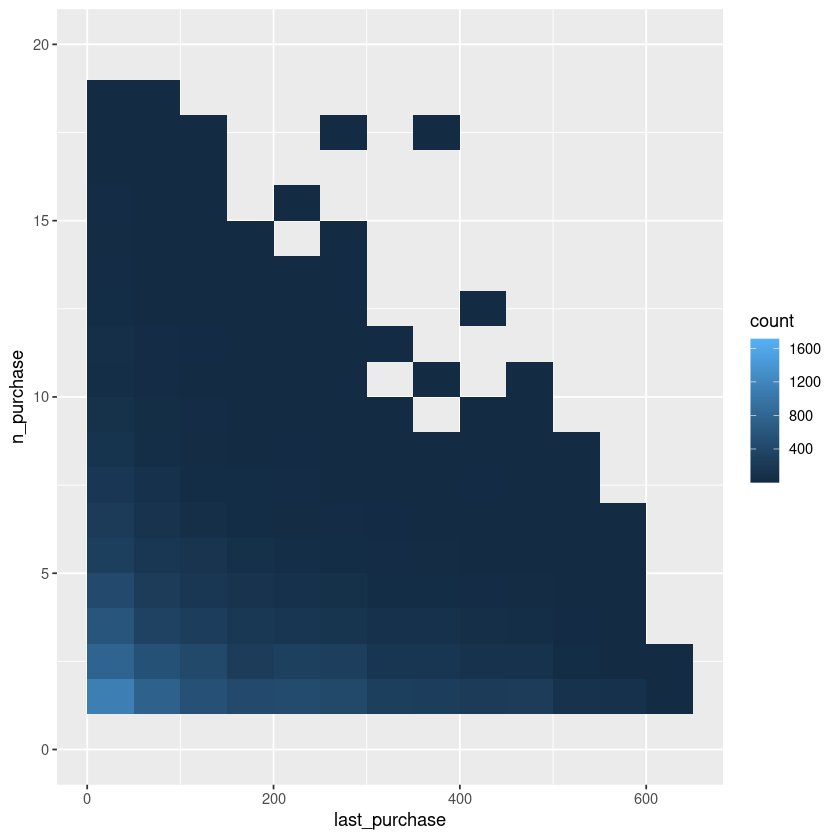

In [24]:
resume_customer %>% ggplot(aes(x=last_purchase, y=n_purchase)) + geom_bin2d(binwidth=c(50, 1))+ ylim(0, 20)

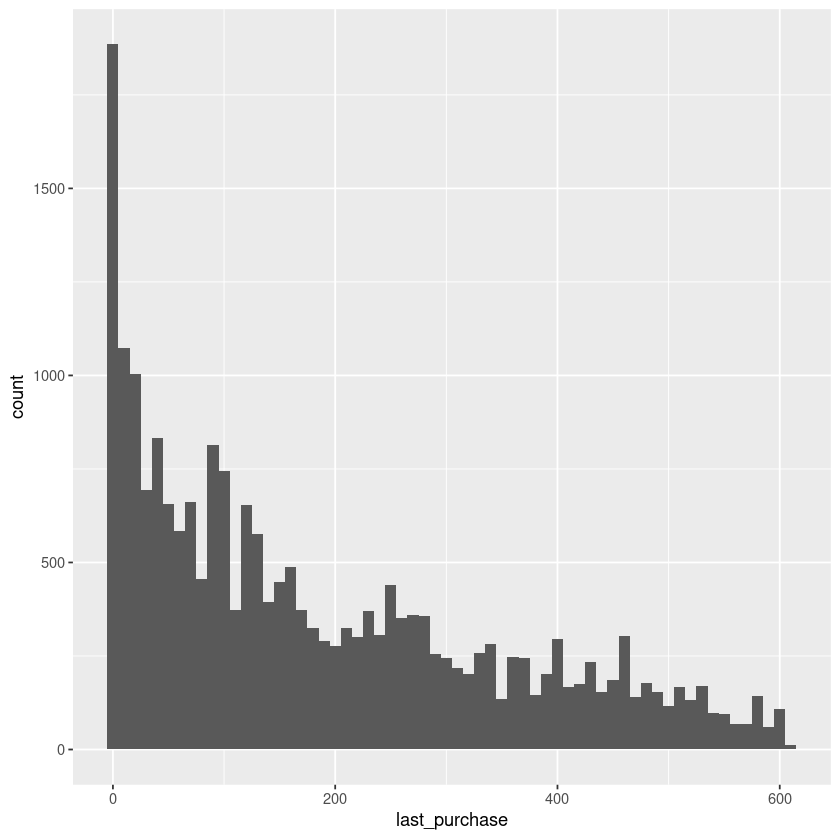

In [25]:
resume_customer %>% ggplot(aes(x=last_purchase)) + geom_histogram(binwidth = 10)

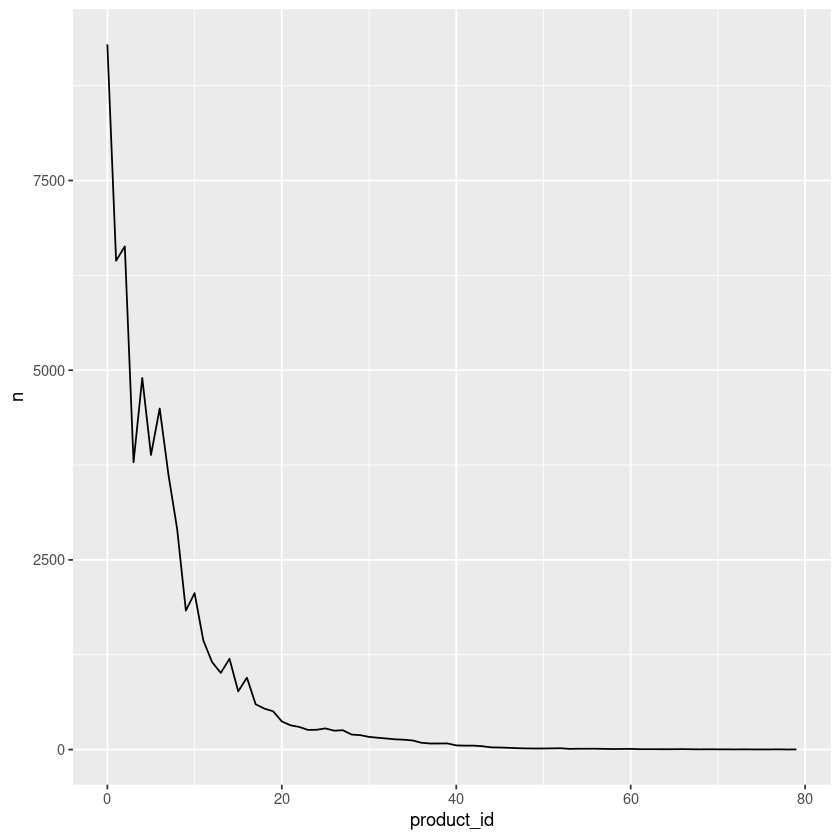

In [26]:
df_clean %>% count(product_id)  %>%  ggplot(aes(x=product_id, y=n)) + geom_line()

# Modeling
## Base model 

In [27]:
base_model <- ranger(churn ~ .,
                     data = churn_train, 
                     importance = "impurity",
                     classification = TRUE,
                     probability = FALSE
                    )

In [28]:
base_model

Ranger result

Call:
 ranger(churn ~ ., data = churn_train, importance = "impurity",      classification = TRUE, probability = FALSE) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      17648 
Number of independent variables:  27 
Mtry:                             5 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             27.49 % 

In [29]:
predict(base_model, data = churn_train)$predictions[1:20]

[1] 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1

In [30]:
pred_class = predict(base_model, data = churn_train)$predictions
confusionMatrix(
  data = as.factor(pred_class), 
  reference = as.factor(churn_train$churn),
  mode='everything'
)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5479  384
         1 2606 9179
                                         
               Accuracy : 0.8306         
                 95% CI : (0.825, 0.8361)
    No Information Rate : 0.5419         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6514         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.6777         
            Specificity : 0.9598         
         Pos Pred Value : 0.9345         
         Neg Pred Value : 0.7789         
              Precision : 0.9345         
                 Recall : 0.6777         
                     F1 : 0.7856         
             Prevalence : 0.4581         
         Detection Rate : 0.3105         
   Detection Prevalence : 0.3322         
      Balanced Accuracy : 0.8188         
  

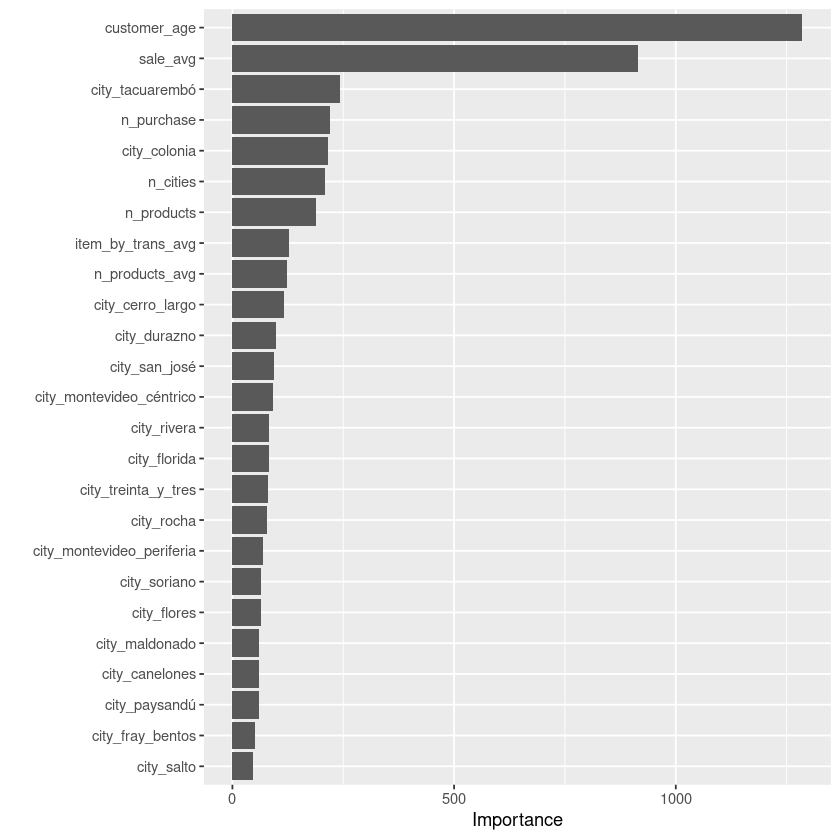

In [31]:
p1 <- vip::vip(base_model, num_features = 25, )
p1

## Base model with probability
### Ranger

In [32]:
base_prob_ranger <- ranger(churn ~ .,
                     data = churn_train, 
                     importance = "impurity",
                     classification = TRUE,
                     probability = TRUE
                    )

In [33]:
result_ranger  <- data.frame(obs = churn_train$churn,
                             pred_prob = predict(base_prob_ranger, data = churn_train)$predictions[,2]
                            )

In [34]:
head(result_ranger)

,obs,pred_prob
,<int>,<dbl>
1,0,0.6715464
2,0,0.5264825
3,1,0.6822893
4,1,0.7501425
5,1,0.8962105
6,1,0.7133803


#### Calibrating probabilities


In [35]:
# Calibrating probabilities
cal_curve_ranger <- caret::calibration(x = as.factor(obs) ~ pred_prob, data = result_ranger, class=1)
cal_curve_ranger$data

calibModelVar,bin,Percent,Lower,Upper,Count,midpoint
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pred_prob,"[0,0.0909]",0.0000000,0.00000000,0.1757576,0,4.545455
pred_prob,"(0.0909,0.182]",0.3378378,0.06972455,0.9841040,3,13.636364
pred_prob,"(0.182,0.273]",1.9498607,1.07000599,3.2499123,14,22.727273
pred_prob,"(0.273,0.364]",8.9238845,6.99627026,11.1760749,68,31.818182
pred_prob,"(0.364,0.455]",16.9851380,14.64032488,19.5383906,160,40.909091
pred_prob,"(0.455,0.545]",33.0000000,30.44633269,35.6307778,429,50.000000
pred_prob,"(0.545,0.636]",44.9616123,42.81021978,47.1271972,937,59.090909
pred_prob,"(0.636,0.727]",78.9062500,77.58109451,80.1872670,3030,68.181818
pred_prob,"(0.727,0.818]",97.2132210,96.56967188,97.7650288,3000,77.272727


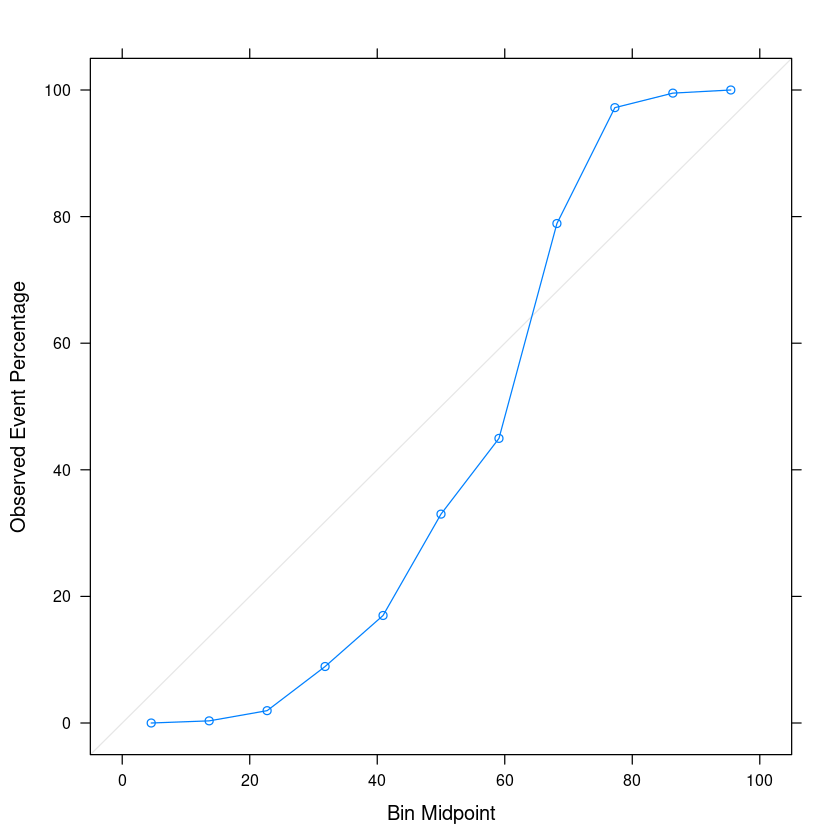

In [36]:
xyplot(cal_curve_ranger)

### randomForest

In [37]:
base_prob_rF <- randomForest(as.factor(churn) ~ .,
                     data = churn_train,
                     importance = TRUE
                    )

In [38]:
result_rF  <- data.frame(obs = churn_train$churn,
                         pred_prob = predict(base_prob_rF, data = churn_train, type="prob")[, 2]
                        )

In [39]:
head(result_rF)

,obs,pred_prob
,<int>,<dbl>
1,0,0.9500000
2,0,0.7454545
3,1,0.9723757
4,1,1.0000000
5,1,1.0000000
6,1,1.0000000


#### Calibrating probabilities

In [40]:
# Calibrating probabilities
cal_curve_rF <- caret::calibration(x = as.factor(obs) ~ pred_prob, data = result_rF, class=1)
cal_curve_rF$data

calibModelVar,bin,Percent,Lower,Upper,Count,midpoint
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pred_prob,"[0,0.0909]",3.421882,2.705335,4.264454,76,4.545455
pred_prob,"(0.0909,0.182]",17.272727,14.831280,19.935502,152,13.636364
pred_prob,"(0.182,0.273]",26.566416,23.530538,29.776521,212,22.727273
pred_prob,"(0.273,0.364]",39.060206,35.376731,42.838912,266,31.818182
pred_prob,"(0.364,0.455]",47.260274,43.587524,50.955245,345,40.909091
pred_prob,"(0.455,0.545]",49.116998,45.813945,52.425809,445,50.000000
pred_prob,"(0.545,0.636]",53.024575,49.965125,56.067157,561,59.090909
pred_prob,"(0.636,0.727]",57.600000,54.805194,60.358976,720,68.181818
pred_prob,"(0.727,0.818]",60.594315,58.109585,63.038774,938,77.272727


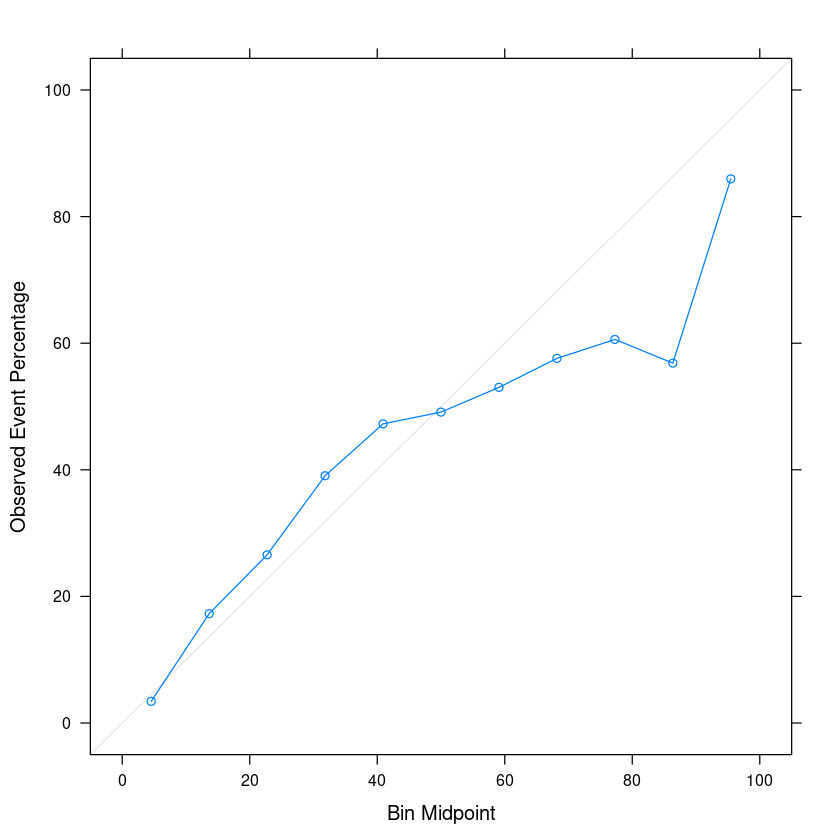

In [41]:
xyplot(cal_curve_rF, auto.key = list(columns =2))

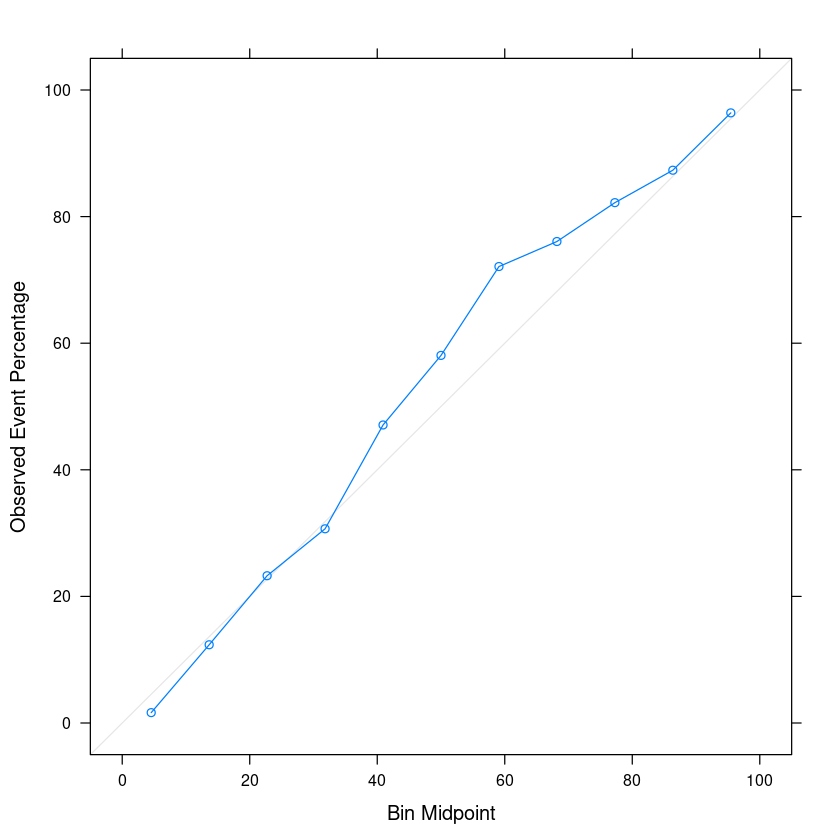

In [42]:
# Calibrate probabilities
result_rF$calibrated <- probability.calibration(y = result_rF$obs,
                                                p = result_rF$pred_prob) 

cal_curve_rF <- caret::calibration(x = as.factor(obs) ~ calibrated,
                               data = result_rF,
                               class = 1)
xyplot(cal_curve_rF, auto.key = list(columns =2))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



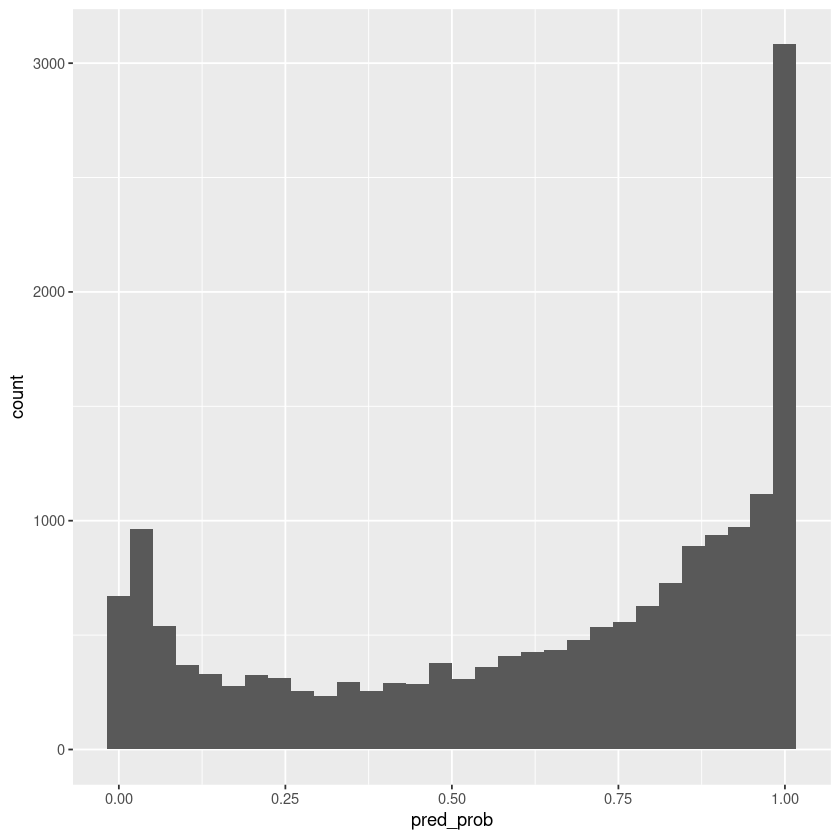

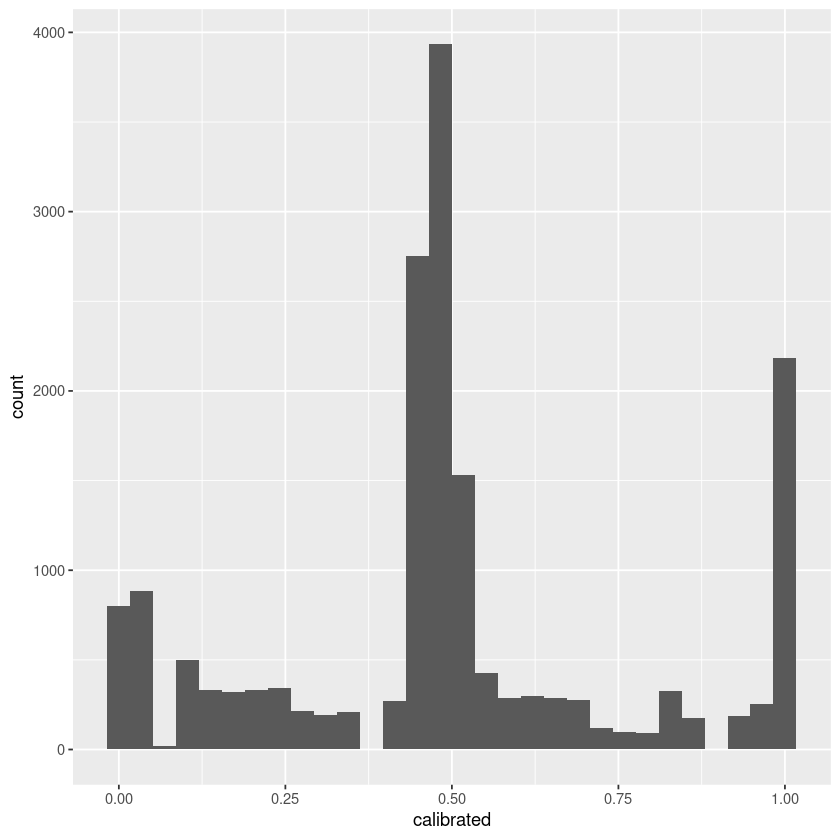

In [51]:
result_rF %>% 
    ggplot(aes(pred_prob)) +
        geom_histogram()

result_rF %>% 
    ggplot(aes(calibrated)) +
        geom_histogram()

### PDP
In the above plot, please do not get confused with Y-axis. It does not show the predicted value instead how the value is changing with the change in the given predictor variable in our case Petal.Width in first plot.

In the plot if there are more variation for any given predictor variable that means the value of that variable affects the model quite alot but if the line is constant near zero it shows that variable has no affect on the model.

Single variables shows how there value affect the model, on y-axis having a negative value means for that particular value of predictor variable it is less likely to predict the correct class on that observation and having a positive value means it has positive impact on predicting the correct class. Same applies to two variable plots, color represent the intensity of affect on model.

https://bgreenwell.github.io/pdp/articles/pdp.html

In [44]:
pd <- pdp::partial(base_prob_ranger,
              pred.var = c("city_colonia"),
              chull = TRUE,
              which.class=2,
              type="classification",
             )

Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”


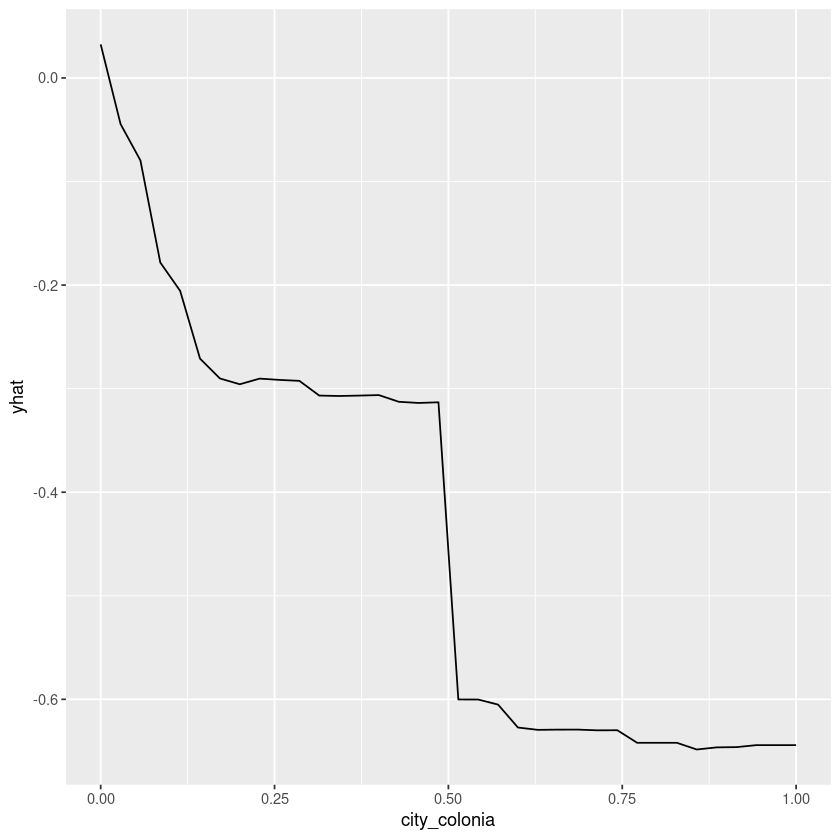

In [45]:
autoplot(pd, contour = TRUE)

## Plots

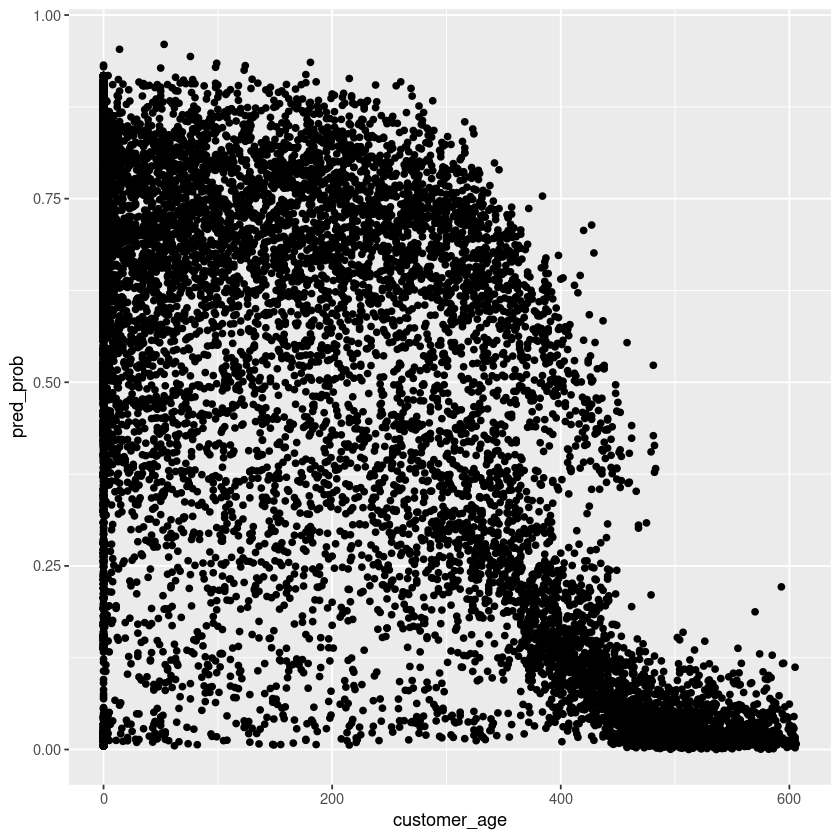

In [46]:
churn_train %>% 
    mutate(pred_prob = result_ranger$pred_prob) %>% 
    ggplot(aes(customer_age, pred_prob)) +
        geom_point()

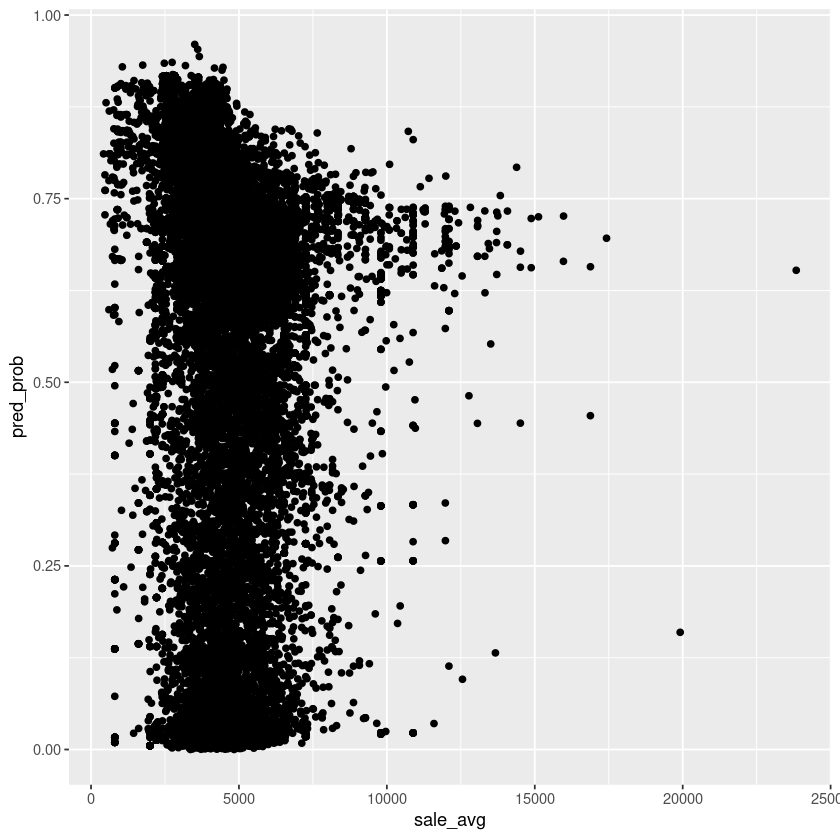

In [47]:
churn_train %>% 
    mutate(pred_prob = result_ranger$pred_prob) %>% 
    ggplot(aes(sale_avg, pred_prob)) +
        geom_point()

Warning message:
“Removed 16 rows containing missing values (geom_point).”


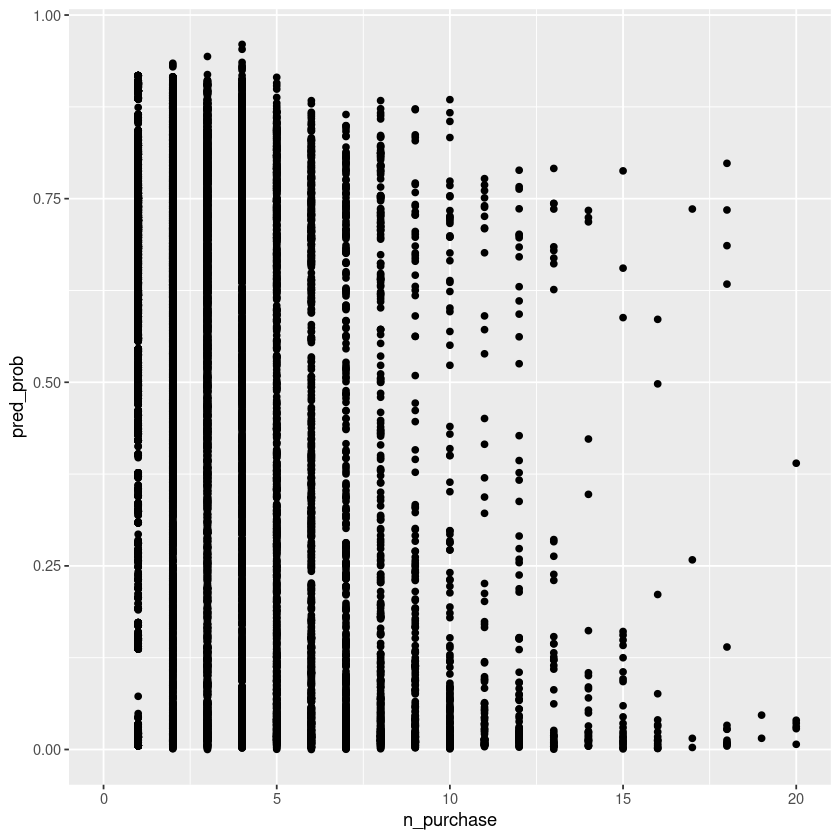

In [48]:
churn_train %>% 
    mutate(pred_prob = result_ranger$pred_prob) %>% 
    ggplot(aes(n_purchase, pred_prob)) +
        geom_point() + 
        xlim(0, 20)

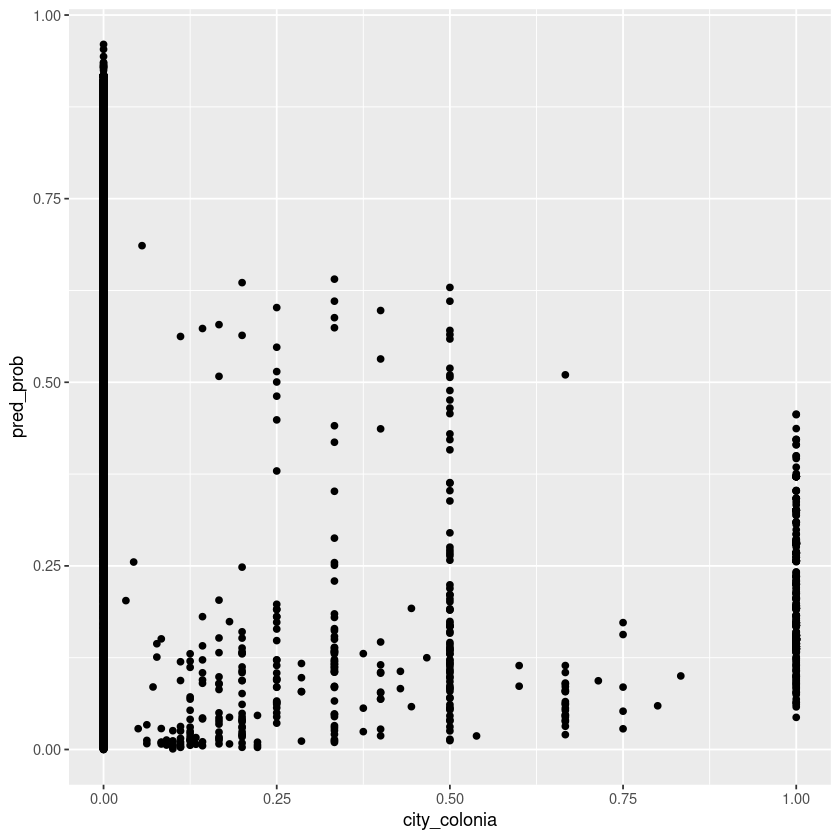

In [49]:
churn_train %>% 
    mutate(pred_prob = result_ranger$pred_prob) %>% 
    ggplot(aes(city_colonia, pred_prob)) +
        geom_point() + 
        xlim(0, 1)